In [1]:
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import keras
import tensorflow as tf
import helpers as hp
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Input, Lambda, Dense, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras import optimizers
from keras.utils import to_categorical
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
print("Number of GPUs available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5246100863496883543
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14870209509221315527
physical_device_desc: "device: XLA_CPU device"
]
Number of GPUs available:  0



In [2]:
# set to image directory
cov = glob.glob(os.getcwd()+'/covid-chestxray-dataset-master/output/*')
pne = glob.glob(os.getcwd()+'/pneumonia2/*')

# parameters
cov_train_num = 100
pne_train_num = 100

# select random subset of images for training
cov_train = np.random.choice(cov,size=cov_train_num,replace=False)
pne_train = np.random.choice(pne,size=pne_train_num,replace=False)
cov_test = list(set(cov)-set(cov_train))
pne_test = list(set(pne)-set(pne_train))

cov_test_num = len(cov_test)
pne_test_num = len(pne_test)

print('COVID training set size: '+str(cov_train_num))
print('Pneumonia training set size: '+str(pne_train_num))
print('Total training set size: '+str(cov_train_num+pne_train_num))
print()
print('COVID testing set size: '+str(cov_test_num))
print('Pneumonia testing set size: '+str(pne_test_num))
print('Total testing set size: '+str(cov_test_num+pne_test_num))
print()

IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_DIM = (IMG_WIDTH,IMG_HEIGHT)

# load training images
cov_train_imgs = [img_to_array(load_img(img,target_size=IMG_DIM,color_mode="rgb")) for img in cov_train]
pne_train_imgs = [img_to_array(load_img(img,target_size=IMG_DIM,color_mode="rgb")) for img in pne_train]

# create corresponding labels
train_imgs = np.array(cov_train_imgs+pne_train_imgs)
train_imgs_scaled = train_imgs.astype('float32')/255
train_labels = np.array(cov_train_num*[1]+pne_train_num*[0])
train_labels_enc = to_categorical(train_labels)

# load test images and create corresponding labels
cov_test_imgs = [img_to_array(load_img(img,target_size=IMG_DIM,color_mode="rgb")) for img in cov_test]
pne_test_imgs = [img_to_array(load_img(img,target_size=IMG_DIM,color_mode="rgb")) for img in pne_test]
test_imgs = np.array(cov_test_imgs+pne_test_imgs)
test_imgs_scaled = test_imgs.astype('float32')/255
test_labels = np.array(cov_test_num*[1]+pne_test_num*[0])
test_labels_enc = to_categorical(test_labels)

COVID training set size: 100
Pneumonia training set size: 100
Total training set size: 200

COVID testing set size: 79
Pneumonia testing set size: 222
Total testing set size: 301



In [3]:
from keras import backend as K

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 2
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 1, y_true.dtype)))

In [4]:
# load weights from siamese network
adm = optimizers.Adam(lr=0.0001)
vgg_siamese = load_model('weights_vggtwin_tr19900_ep10.h5',compile=False)
vgg_siamese.compile(loss=hp.contrastive_loss, optimizer=adm, metrics=[hp.accuracy])

# create traditional classifier
adm = optimizers.Adam(lr=0.0001)
input_shape = (IMG_HEIGHT,IMG_WIDTH,train_imgs.shape[3])
from keras.layers import BatchNormalization
extracted_network = vgg_siamese.get_layer('model_1')
extracted_network.trainable = False
input = Input(shape=input_shape)
x = extracted_network(input)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(2, activation='softmax')(x)
vgg_traditional = Model(input,x)

In [5]:
# train model
epochs = 100;
vgg_traditional.compile(loss='categorical_crossentropy', optimizer=adm, metrics=['accuracy'])
vgg_traditional.summary()
vgg_traditional.fit(train_imgs_scaled,train_labels_enc,
    batch_size=30,
    epochs=epochs,
    # validation_data=(test_imgs_scaled,test_labels_enc),
    shuffle=True)

train_labels_pred = vgg_traditional.predict(train_imgs_scaled)
train_acc = np.mean(train_labels==np.argmax(train_labels_pred,axis=1))
test_labels_pred = vgg_traditional.predict(test_imgs_scaled)
test_acc = np.mean(test_labels==np.argmax(test_labels_pred,axis=1))
print('Predicted labels:')
print(test_labels_pred)
print()
print('* Accuracy on training set: %0.2f%%' % (100 * train_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * test_acc))
print()

tp,tn,fp,fn,sensitivity,specificity = hp.generate_metrics(test_labels,np.argmax(test_labels_pred,axis=1))
print('True positives: '+str(tp))
print('True negatives: '+str(tn))
print('False positives: '+str(fp))
print('False negatives: '+str(fn))
print('Sensitivity: '+str(sensitivity))
print('Specificity: '+str(specificity))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
model_1 (Model)              (None, 128)               14796864  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 14,805,506
Trainable params: 8,514
Non-trainable params: 14,796,992
___________________________________________

200/200 [==============================] - 34s 168ms/step - loss: 0.1531 - accuracy: 0.9500
Epoch 69/100
200/200 [==============================] - 30s 151ms/step - loss: 0.1493 - accuracy: 0.9500
Epoch 70/100
200/200 [==============================] - 33s 167ms/step - loss: 0.1726 - accuracy: 0.9450
Epoch 71/100
200/200 [==============================] - 31s 153ms/step - loss: 0.1640 - accuracy: 0.9400
Epoch 72/100
200/200 [==============================] - 31s 154ms/step - loss: 0.1580 - accuracy: 0.9450
Epoch 73/100
200/200 [==============================] - 30s 150ms/step - loss: 0.1968 - accuracy: 0.9400
Epoch 74/100
200/200 [==============================] - 30s 150ms/step - loss: 0.1518 - accuracy: 0.9550
Epoch 75/100
200/200 [==============================] - 31s 153ms/step - loss: 0.1741 - accuracy: 0.9550
Epoch 76/100
200/200 [==============================] - 30s 150ms/step - loss: 0.1452 - accuracy: 0.9500
Epoch 77/100
200/200 [==============================] - 30s 150ms/st

1


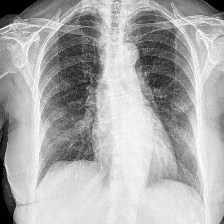

In [38]:
print(test_labels[0])
array_to_img(test_imgs_scaled[0])

In [14]:
import lime
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(test_imgs_scaled[0], vgg_traditional.predict, top_labels=5, hide_color=0, num_samples=1000)

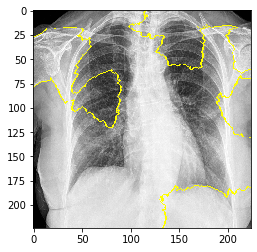

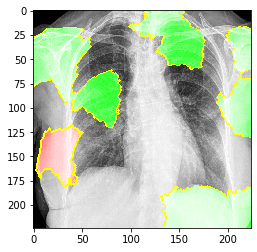

In [25]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.figure()
plt.imshow(mark_boundaries(temp, mask))

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.figure()
plt.imshow(mark_boundaries(temp, mask))